In [14]:
# 

In [15]:
import os
import re
import json
import csv
import datetime
from langchain.prompts import PromptTemplate
from genai.credentials import Credentials
import os
from dotenv import load_dotenv
# Using Generative AI Library
from genai.model import Model
from genai.schemas import GenerateParams
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Suppress all warnings
import warnings
import concurrent.futures
import glob
from tqdm import tqdm

warnings.simplefilter("ignore")
pd.set_option('display.max_colwidth', 100)  # Adjust the number as needed


In [16]:
### snapshot utils! ###

def create_snapshot(df):
    now = datetime.datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M")
    df.to_csv(f'data/reuters_headlines_{timestamp}.csv', index=False)
    print(f'Snapshot created: data/reuters_headlines_{timestamp}.csv')
    
# load the latest csv backup file into a dataframe
def get_latest_csv_file_path():
    list_of_files = glob.glob('data/reuters_headlines_*.csv') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

def load_latest_snapshot_from_csv():
    df = pd.read_csv(get_latest_csv_file_path())
    try:
        df['named_entities'] = df['named_entities'].apply(ast.literal_eval)
    except:
        pass
    return df


## 1. Load data

This is an open source data set from https://www.kaggle.com/datasets/notlucasp/financial-news-headlines/

In [17]:
# read the csv file data/reuters_headlines.csv into a dataframe
df = pd.read_csv('data/reuters_headlines.csv',nrows=10000)
df.head()


,Headlines,Time,Description
0,TikTok considers London and other locations for headquarters,Jul 18 2020,TikTok has been in discussions with the UK government over the past few months to locate its hea...
1,Disney cuts ad spending on Facebook amid growing boycott: WSJ,Jul 18 2020,Walt Disney has become the latest company to slash its advertising spending on Facebook Inc as...
2,"Trail of missing Wirecard executive leads to Belarus, Der Spiegel reports",Jul 18 2020,Former Wirecard chief operating officer Jan Marsalek travelled to Minsk soon after he was suspe...
3,Twitter says attackers downloaded data from up to eight non-verified accounts,Jul 18 2020,Twitter Inc said on Saturday that hackers were able to download account information for up to ei...
4,U.S. Republicans seek liability protections as coronavirus aid battle looms,Jul 17 2020,A battle in the U.S. Congress over a new coronavirus-aid bill began on Friday as Republicans wer...


In [18]:
df.describe()

,Headlines,Time,Description
count,10000,10000,10000
unique,9943,228,9943
top,Factbox: What changes are companies making in response to George Floyd protests?,Mar 19 2020,Airlines across the globe are feeling the pain as travel demand withers because of the coronavir...
freq,4,126,4


## 2. setup connection to watsonx.ai

This is needed to access the hosted models within watsonx.ai via the API.

In [19]:
load_dotenv()
api_key = os.getenv("GENAI_KEY")
api_url = os.getenv("GENAI_API")

creds = Credentials(api_key, api_endpoint=api_url) # credentials object to access the LLM service

In [20]:
# # a helper function to generate text
# def get_completion(sample, prompt_string, model):
#     prompt_template = PromptTemplate.from_template(prompt_string)
#     prompt=prompt_template.format(sample=sample)
#     result=model.generate([prompt])[0].generated_text
#     return result

# a helper function to generate text with an optional second sample
def get_completion(sample1, prompt_string, model, sample2=None):
    prompt_template = PromptTemplate.from_template(prompt_string)
    
    # Format the prompt with one or two samples based on input
    if sample2 is not None:
        prompt = prompt_template.format(sample1=sample1, sample2=sample2)
    else:
        prompt = prompt_template.format(sample=sample1)
    
    result = model.generate([prompt])[0].generated_text
    return result

# 3. Extract named entities!

In [21]:


# Instantiate parameters for text generation
params = GenerateParams(
    decoding_method="greedy", # use 'greedy' alternatively
    # max_new_tokens=1000,
    # min_new_tokens=1,
    # temperature=0.5,
    # repetition_penalty=1.2,
    # top_k=50,
    # top_p=1,
)

# Instantiate a model proxy object to send your requests

# llama 2 --> 100 rows = 180 seconds --> 1 row = 1.8 seconds --> 30000 rows = 54000 seconds = 15 hours
llame_2_70b_model = Model("meta-llama/llama-2-70b-chat", params=params, credentials=creds)
# granite-13b-instruct-v1 --> 100 rows = 90 seconds --> 1 row = 0.9 seconds --> 30000 rows = 27000 seconds = 7.5 hours
granite_13_instruct_model = Model("ibm/granite-13b-instruct-v1", params=params, credentials=creds)

In [22]:
prompt_string_named_entities="""
Act as a webmaster who must extract structured information from emails. Read the below email and extract and categorize each entity.


Input:
"Golden Bank is a competitor of Silver Bank in the US" said John Doe.

Output: (Named Entities)
Golden Bank: company, Silver Bank: company, US: country, John Doe: person

Input:
Alphabet Inc's Google said on Friday it would prohibit websites and apps that use its advertising technology from running ads on "dangerous content" that goes against scientific consensus during the coronavirus pandemic.

Output: (Named Entities)
Alphabet Inc: company,  Google: company division, Friday: day of the week, coronavirus pandemic: event

Input:
Amazon.com Inc has extended a work-from-home policy until Jan. 8 and is continuing to ask employees to defer all non-essential travel, a spokeswoman said on Wednesday.

Output: (Named Entities)
Amazon: company

Input:
Wells Fargo & Co will launch a broad cost-cutting initiative this year, executives said on Tuesday, as the bank braces for massive loan losses caused by the coronavirus pandemic and continues to work through expensive regulatory and operational problems tied to a long-running sales scandal.

Output: (Named Entities)
Wells Fargo & Co: company, loan losses: event, coronavirus pandemic: event

Input:
{sample}

Output: (Named Entities)
"""

In [23]:
# Util function to parse a string into a list of tuples
def parse_string_to_touple_list(input_str):
    # Regular expression pattern to match 'key: value' pairs
    # Adjust the pattern as needed to handle different formats
    pattern = r'(\w[\w\s]*?)\s*:\s*([\w\s]+)'

    # Find all matches and convert them to tuples
    tuples_list = re.findall(pattern, input_str)
    
    # remove any leading or trailing spaces as well as newlines from the keys and values
    tuples_list = [(key.strip(), value.strip()) for key, value in tuples_list]   
    
    return tuples_list



# A small test
input_str = "TikTok: company, UK government: organization, London: location, China: country "
print(parse_string_to_touple_list(input_str))	

[('TikTok', 'company'), ('UK government', 'organization'), ('London', 'location'), ('China', 'country')]


In [24]:
################################################
### SLOW --> Only for development purposes  ###
################################################

# df_copy = df.copy()
# # Initialize the 'named_entities' column with default values
# df_copy['named_entities'] = [None] * len(df_copy)

# for i in range(df_copy.shape[0]):
#     named_entities=get_completion(df_copy['Description'][i], prompt_string_named_entities, granite_13_instruct_model)
#     # parse the named_entities string into a list of tuples and store it in a new column called 'named_entities'
#     df_copy['named_entities'][i] = parse_string_to_touple_list(named_entities)
    
# df_copy.head(10)

In [25]:
################################################################
### FAST --> 10x parallelised --> this can get expensive :-P ###
################################################################

# Function to process each row
def process_row(index, row):
    named_entities = get_completion(row['Description'], prompt_string_named_entities, granite_13_instruct_model)
    return index, parse_string_to_touple_list(named_entities)

# Initialize the 'named_entities' column
df['named_entities'] = None

# Using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_row, i, row) for i, row in df.iterrows()]

    for future in concurrent.futures.as_completed(futures):
        index, named_entities = future.result()
        df.at[index, 'named_entities'] = named_entities

In [26]:
create_snapshot(df)

Snapshot created: data/reuters_headlines_20231115_1545.csv


### clean up the named_entities column

analyze named entities to filter out the ones that are not relevant for our analysis

In [27]:
df.head(10)

,Headlines,Time,Description,named_entities
0,TikTok considers London and other locations for headquarters,Jul 18 2020,TikTok has been in discussions with the UK government over the past few months to locate its hea...,"[(TikTok, company), (headquarters, event), (UK, country)]"
1,Disney cuts ad spending on Facebook amid growing boycott: WSJ,Jul 18 2020,Walt Disney has become the latest company to slash its advertising spending on Facebook Inc as...,"[(Walt Disney, company), (Facebook, company)]"
2,"Trail of missing Wirecard executive leads to Belarus, Der Spiegel reports",Jul 18 2020,Former Wirecard chief operating officer Jan Marsalek travelled to Minsk soon after he was suspe...,"[(Jan Marsalek, person)]"
3,Twitter says attackers downloaded data from up to eight non-verified accounts,Jul 18 2020,Twitter Inc said on Saturday that hackers were able to download account information for up to ei...,"[(Twitter, company)]"
4,U.S. Republicans seek liability protections as coronavirus aid battle looms,Jul 17 2020,A battle in the U.S. Congress over a new coronavirus-aid bill began on Friday as Republicans wer...,"[(Congress, legislative body), (coronavirus, event)]"
5,Wall Street Week Ahead: Fund managers navigate 'Night of the Living Dead' in small caps,Jul 17 2020,"Investors are searching for bargains in the world of U.S. small-caps, as the beaten-down asset c...","[(Investors, group), (caps, asset class), (earnings, event)]"
6,Take Five: Hoping for that V-shape in earnings,Jul 17 2020,We knew Q2 earnings would be dire but the hope was a) they might turn out to be better than fear...,"[(Q2, quarter), (earnings, event), (European, region)]"
7,Evictions nearly back to pre-pandemic levels in some U.S. areas: Cleveland Fed study,Jul 17 2020,Landlords in some areas of the United States are filing to evict rent-delinquent tenants at roug...,"[(Landlords, people), (tenants, people)]"
8,Google bans ads on coronavirus conspiracy theory content,Jul 17 2020,Alphabet Inc's Google said on Friday it would prohibit websites and apps that use its advertisin...,"[(Alphabet Inc, company), (Google, company division), (Friday, day of the week)]"
9,"Flight to suburbs boosts U.S. homebuilding, but COVID-19 surge erodes consumer sentiment",Jul 17 2020,U.S. homebuilding increased in June by the most in nearly four years amid reports of rising dema...,"[(homebuilding, event), (suburban, adjective), (rural, adjective)]"


In [28]:
import pandas as pd
import ast
from collections import Counter
# Load the dataset
df = load_latest_snapshot_from_csv()

# Flatten the list of named entities and extract entity types
entity_types = [entity_type for row in df['named_entities'] for _, entity_type in row]

# Count the frequency of each entity type
entity_type_counts = Counter(entity_types)

# Sort and display the most common entity types
sorted_entity_type_counts = dict(sorted(entity_type_counts.items(), key=lambda item: item[1], reverse=True))

# Print the most common entity types
print(sorted_entity_type_counts)


{'company': 7525, 'event': 2818, 'country': 1852, 'person': 1722, 'organization': 576, 'group': 247, 'amount': 210, 'industry': 197, 'institution': 174, 'number': 174, 'city': 161, 'commodity': 160, 'currency': 151, 'people': 125, 'region': 117, 'state': 110, 'location': 98, 'product': 97, 'agency': 89, 'month': 87, 'index': 81, 'position': 81, 'office': 78, 'aircraft': 75, 'object': 74, 'asset': 71, 'bank': 67, 'airline': 65, 'president': 56, 'continent': 54, 'financial market': 51, 'asset class': 50, 'department': 48, 'companies': 48, 'central bank': 47, 'disease': 46, 'stock price': 43, 'company division': 39, 'government': 39, 'union': 39, 'plural': 38, 'financial instrument': 38, 'Donald Trump': 38, 'business': 36, 'date': 34, 'sector': 33, 'building': 33, 'nationality': 33, 'market': 33, 'legislative body': 32, 'stock': 32, 'symbol': 30, 'adjective': 28, 'vehicle': 28, 'brand': 28, 'occupation': 27, 'financial institution': 26, 'model': 26, 'instrument': 25, 'technology': 25, 'li

create a new row that contains only the named entities that are the most common ones + deleting all rows that do not have on of the common entities --> filtering out a lot of noise

In [29]:
# Identifying the top 5 most common entity types
top_5_entity_types = set([entity for entity, count in sorted_entity_type_counts.items()][:5])
print(top_5_entity_types)

# Filtering out named entities that are not in the top 5 most common types
df['filtered_named_entities'] = df['named_entities'].apply(
    lambda entities: [entity for entity in entities if entity[1] in top_5_entity_types]
)

# Deleting rows where Filtered Named Entities are empty
filtered_df = df[df['filtered_named_entities'].map(bool)]

# Display the first few rows of the filtered dataframe to confirm the operation
filtered_df[['Headlines', 'filtered_named_entities']].head()


{'country', 'organization', 'person', 'event', 'company'}


,Headlines,filtered_named_entities
0,TikTok considers London and other locations for headquarters,"[(TikTok, company), (headquarters, event), (UK, country)]"
1,Disney cuts ad spending on Facebook amid growing boycott: WSJ,"[(Walt Disney, company), (Facebook, company)]"
2,"Trail of missing Wirecard executive leads to Belarus, Der Spiegel reports","[(Jan Marsalek, person)]"
3,Twitter says attackers downloaded data from up to eight non-verified accounts,"[(Twitter, company)]"
4,U.S. Republicans seek liability protections as coronavirus aid battle looms,"[(coronavirus, event)]"


#### split up the named_entities column into multiple columns --> making it a lot easier to work with
At this point we are deleting all rows that have more then one e.g. "company" in them. While those cases sure are interesting, they are too complex for our first analysis.

*assuming the top_5_entitiy_types are {'company', 'country', 'person', 'event', 'organization'}*

In [30]:
def transform_row(row):
    # Creating a dictionary to hold the new columns
    new_row = {'Headlines': row['Headlines'], 'Time': row['Time'],
               'Description': row['Description'],
               'company': None, 'country': None, 'person': None, 'event': None, 'organization': None}

    # Populating the new columns based on the filtered named entities
    for entity, entity_type in row['filtered_named_entities']:
        if new_row[entity_type] is None:
            new_row[entity_type] = entity
        else:
            # If there is already an entity of the same type, skip this row
            return None

    return new_row

# Applying the transformation
transformed_rows = [transform_row(row) for _, row in filtered_df.iterrows()]
transformed_df = pd.DataFrame([row for row in transformed_rows if row is not None])


In [31]:
# delete all rows that do not have a company
transformed_df = transformed_df[transformed_df['company'].map(bool)]

In [32]:
create_snapshot(transformed_df)

Snapshot created: data/reuters_headlines_20231115_1545.csv


# 4. Get sentiment!

This is the first aspect that we are extracting from the raw data

In [33]:
df = load_latest_snapshot_from_csv()

In [34]:
# define model type
#MODELTYPE = "meta-llama/llama-2-70b-chat"
MODELTYPE = "ibm/granite-13b-chat-v1"
# MODELTYPE = "ibm/granite-13b-sft"


# Instantiate parameters for text generation
params = GenerateParams(
    decoding_method="sample", # use 'greedy' alternatively
    max_new_tokens=1000,
    min_new_tokens=1,
    temperature=0.5,
    repetition_penalty=1.2,
    top_k=50,
    top_p=1,
)

# Instantiate a model proxy object to send your requests
granite_13_chat_model = Model(MODELTYPE, params=params, credentials=creds)

In [35]:
prompt_string_sentiment_analysis="""
You are the assistant of fond manager. Your boss wants to have a very quick overview about what current headlines mean for the companies in her portfolio.
Analyze the sentiment of the following financial article. Determine whether the sentiment is positive, negative, or neutral from the perspective of the mentioned company. First consider which company is mentioned in the article then asses the sentiment. Answer with only one word!: 


financial article:
"TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itself from its Chinese ownership." from the perspective of "TikTok"
sentiment: neutral

financial article: "Former BP chief John Browne is stepping down as chairman of Huawei's UK operation ahead of the British government banning the Chinese company from the country's 5G networks later on Tuesday."  from the perspective of "Huawei"#
sentiment: negative

financial article: "Britain will place a "huge priority" on national security when considering Chinese telecoms firm Huawei's role in the country's 5G network, justice minister Robert Buckland said on Monday." from the perspective of "Huawei"
sentiment: negative

financial article: "Prime Minister Boris Johnson is set to ban Huawei from Britain's 5G network in a landmark decision that will anger Beijing but win plaudits from President Donald Trump as the United States grapples with China's rising economic and technological clout." from the perspective of "Huawei"
sentiment: negative

financial article:
"{sample1}" from the perspective of "{sample2}"

sentiment:
"""

go through all cells of the dataset and get the sentiment for each cell. This is highly parallelized.

In [36]:
import concurrent.futures

def process_row_sentiment(index, row):
    sentiment = get_completion(row['Description'], prompt_string_sentiment_analysis, granite_13_chat_model,row['company'])
    return index, sentiment

# Assuming df is your DataFrame
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    # Creating a list of futures
    futures = [executor.submit(process_row_sentiment, i, row) for i, row in df.iterrows()]

    # Retrieving results and updating the DataFrame
    for future in concurrent.futures.as_completed(futures):
        index, sentiment = future.result()
        df.at[index, 'sentiment'] = sentiment


In [37]:
create_snapshot(df)

Snapshot created: data/reuters_headlines_20231115_1550.csv


## 5. Extract key actions!

In [38]:
prompt_string_key_actions="""
You are the assistant of a fond manager. To help your boss you create super short summaries of financial news headlines called "key actions". Those key actions are no more than 3 words. Here are a few examples

Input:
TikTok considers London and other locations for headquarters,Jul 18 2020,"TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itself from its Chinese ownership
Output (2-3 words keyaction):
Locate headquarters

Input:
Disney cuts ad spending on Facebook amid growing boycott: WSJ,Jul 18 2020,"Walt Disney  has become the latest company to slash its advertising spending on Facebook Inc  as the social media giant faces an ad boycott over its handling of hate speech and controversial content, the Wall Street Journal reported on Saturday, citing people familiar with the situation."
Output (2-3 words keyaction):
Slash advertising

Input:
Twitter says attackers downloaded data from up to eight non-verified accounts,Jul 18 2020,Twitter Inc said on Saturday that hackers were able to download account information for up to eight accounts involved in the hack of its systems this week, but said none of them were verified accounts.
Output (2-3 words keyaction):
Hackers downloaded data

Input:
U.S. Republicans seek liability protections as coronavirus aid battle looms,Jul 17 2020,A battle in the U.S. Congress over a new coronavirus-aid bill began on Friday as Republicans were putting the finishing touches on provisions granting liability protections for a wide range of entities resuming operations amid the pandemic.
Output (2-3 words keyaction):
Seek liability protections

Input:
Senator asks Twitter about claim worker was paid to help with hack,Jul 17 2020,"Senator Josh Hawley, a Republican who closely follows tech issues, pressed Twitter Chief Executive Jack Dorsey on Friday on whether a company employee had been paid to assist with a hack of high-profile accounts this week aimed at scamming readers."
Output (2-3 words keyaction):
Senator asks

Now you do it:

Input:
{sample}

Output (2-3 words keyaction):
"""

In [39]:
# Instantiate parameters for text generation
params = GenerateParams(
    decoding_method="greedy", # use 'greedy' alternatively
    max_new_tokens=9,
    stop_sequences= ["\n"]
    # min_new_tokens=1,
    # temperature=0.5,
    # repetition_penalty=1.2,
    # top_k=50,
    # top_p=1,
)

# Instantiate a model proxy object to send your requests

# llama 2 --> 100 rows = 180 seconds --> 1 row = 1.8 seconds --> 30000 rows = 54000 seconds = 15 hours
llame_2_70b_model_key_actions = Model("meta-llama/llama-2-70b-chat", params=params, credentials=creds)
# granite-13b-instruct-v1 --> 100 rows = 90 seconds --> 1 row = 0.9 seconds --> 30000 rows = 27000 seconds = 7.5 hours
# granite_13_instruct_model = Model("ibm/granite-13b-instruct-v1", params=params, credentials=creds)

In [40]:
# df_copy = df.copy()
# # Initialize the 'named_entities' column with default values
# df_copy['key_action'] = [None] * len(df_copy)

# for i in range(df.shape[0]):
#     key_action=get_completion(df['Description'][i], prompt_string_key_actions, llame_2_70b_model_key_actions)
#     print(key_action)
#     # remove newlines and trailing spaces
#     key_action = key_action.replace('\n', '').strip()
#     df['key_action'][i] = key_action
    
# df_copy.head(10)

In [41]:
################################################################
### FAST --> 10x parallelised --> this can get expensive :-P ###
################################################################



df=load_latest_snapshot_from_csv()


def process_row(index, row):
    retries = 3  # Number of retries
    delay = 5    # Delay in seconds between retries

    for attempt in range(retries):
        try:
            # Extracting key actions
            key_action = get_completion(row['Description'], prompt_string_key_actions, llame_2_70b_model_key_actions)
            
            # Cleaning the key action string
            key_action = key_action.replace('\n', '').strip()
            
            return index, key_action

        except Exception as e:
            if attempt < retries - 1:
                # Wait for some time before retrying
                time.sleep(delay)
            else:
                raise e  # Re-raise the last exception if all retries fail

# Assuming df is your original DataFrame
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    # Submitting all tasks and storing futures in a list
    futures = [executor.submit(process_row, i, row) for i, row in df.iterrows()]

    # Creating a tqdm progress bar
    with tqdm(total=len(futures)) as progress_bar:
        for future in concurrent.futures.as_completed(futures):
            # Updating the progress bar as each future is completed
            progress_bar.update(1)
            
            # Retrieving results and updating the DataFrame
            index, key_action = future.result()
            df.at[index, 'key_action'] = key_action


100%|██████████| 4357/4357 [10:28<00:00,  6.93it/s]


In [42]:
df.describe()

,Headlines,Time,Description,company,country,person,event,organization,sentiment,key_action
count,4357,4357,4357,4357,425,650,472,86,4357,4357
unique,4345,227,4345,1170,81,367,306,49,3,3749
top,Factbox: More companies join Facebook ad boycott bandwagon,Mar 17 2020,Boeing Co said on Tuesday it does not expect to win approval for the return of the 737 MAX to se...,Tesla,China,Elon Musk,coronavirus,European Union,negative,Beat estimates
freq,3,51,2,133,72,33,36,14,2185,19


In [52]:
df=load_latest_snapshot_from_csv()


In [60]:
# delete all rows that have a company that is called "Co" (nothing else, just "Co")
df = df[df['company'] != 'Co']


In [61]:
df.describe()

,Headlines,Time,Description,company,country,person,event,organization,sentiment,key_action
count,4266,4266,4266,4266,420,629,460,84,4266,4264
unique,4256,227,4256,1169,81,356,302,47,3,3673
top,Factbox: More companies join Facebook ad boycott bandwagon,Mar 17 2020,With temperature scanners on the door and tables partitioned by plexiglass shields in the breako...,Tesla,China,Elon Musk,coronavirus,European Union,negative,Beat estimates
freq,3,46,2,133,70,33,34,14,2157,19


In [62]:
create_snapshot(df)

Snapshot created: data/reuters_headlines_20231115_1604.csv


## 5 Visualizing results!

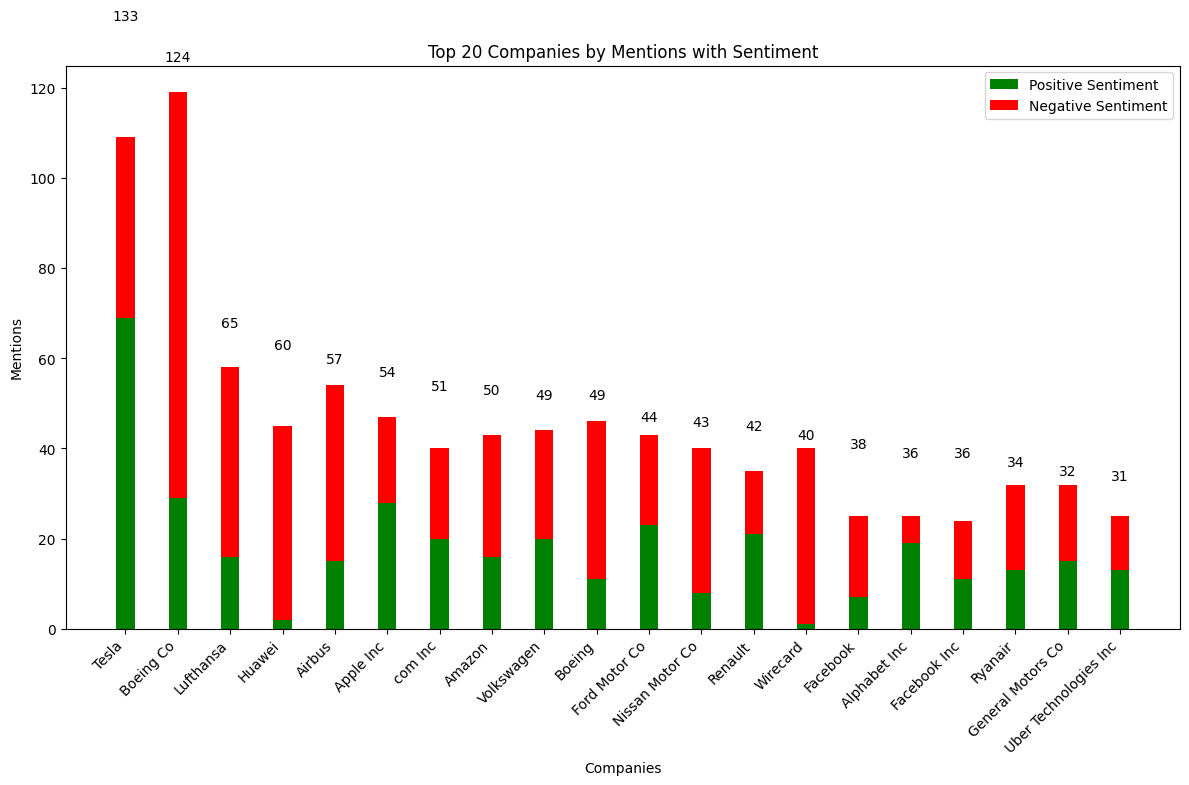

In [63]:
from collections import Counter
import matplotlib.pyplot as plt

df=load_latest_snapshot_from_csv()

# Count occurrences of each company
company_count = Counter(df['company'])

# Prepare data for positive and negative sentiment counts
positive_counts = Counter(df[df['sentiment'] == 'positive']['company'])
negative_counts = Counter(df[df['sentiment'] == 'negative']['company'])

# Select top N companies for visualization
top_n = 20
top_companies = company_count.most_common(top_n)

# Prepare data for plotting
companies = [company[0] for company in top_companies]
total_counts = [company[1] for company in top_companies]
pos_counts = [positive_counts[company] for company in companies]
neg_counts = [negative_counts[company] for company in companies]

# Plotting
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = range(len(companies))

bar1 = plt.bar(index, pos_counts, bar_width, label='Positive Sentiment', color='green')
bar2 = plt.bar(index, neg_counts, bar_width, label='Negative Sentiment', color='red', bottom=pos_counts)

plt.xlabel('Companies')
plt.ylabel('Mentions')
plt.title('Top 20 Companies by Mentions with Sentiment')
plt.xticks(index, companies, rotation=45, ha="right")
plt.legend()

# Add total counts as text above bars
for i in range(len(companies)):
    plt.text(i, total_counts[i] + 2, str(total_counts[i]), ha = 'center')

plt.tight_layout()
plt.show()



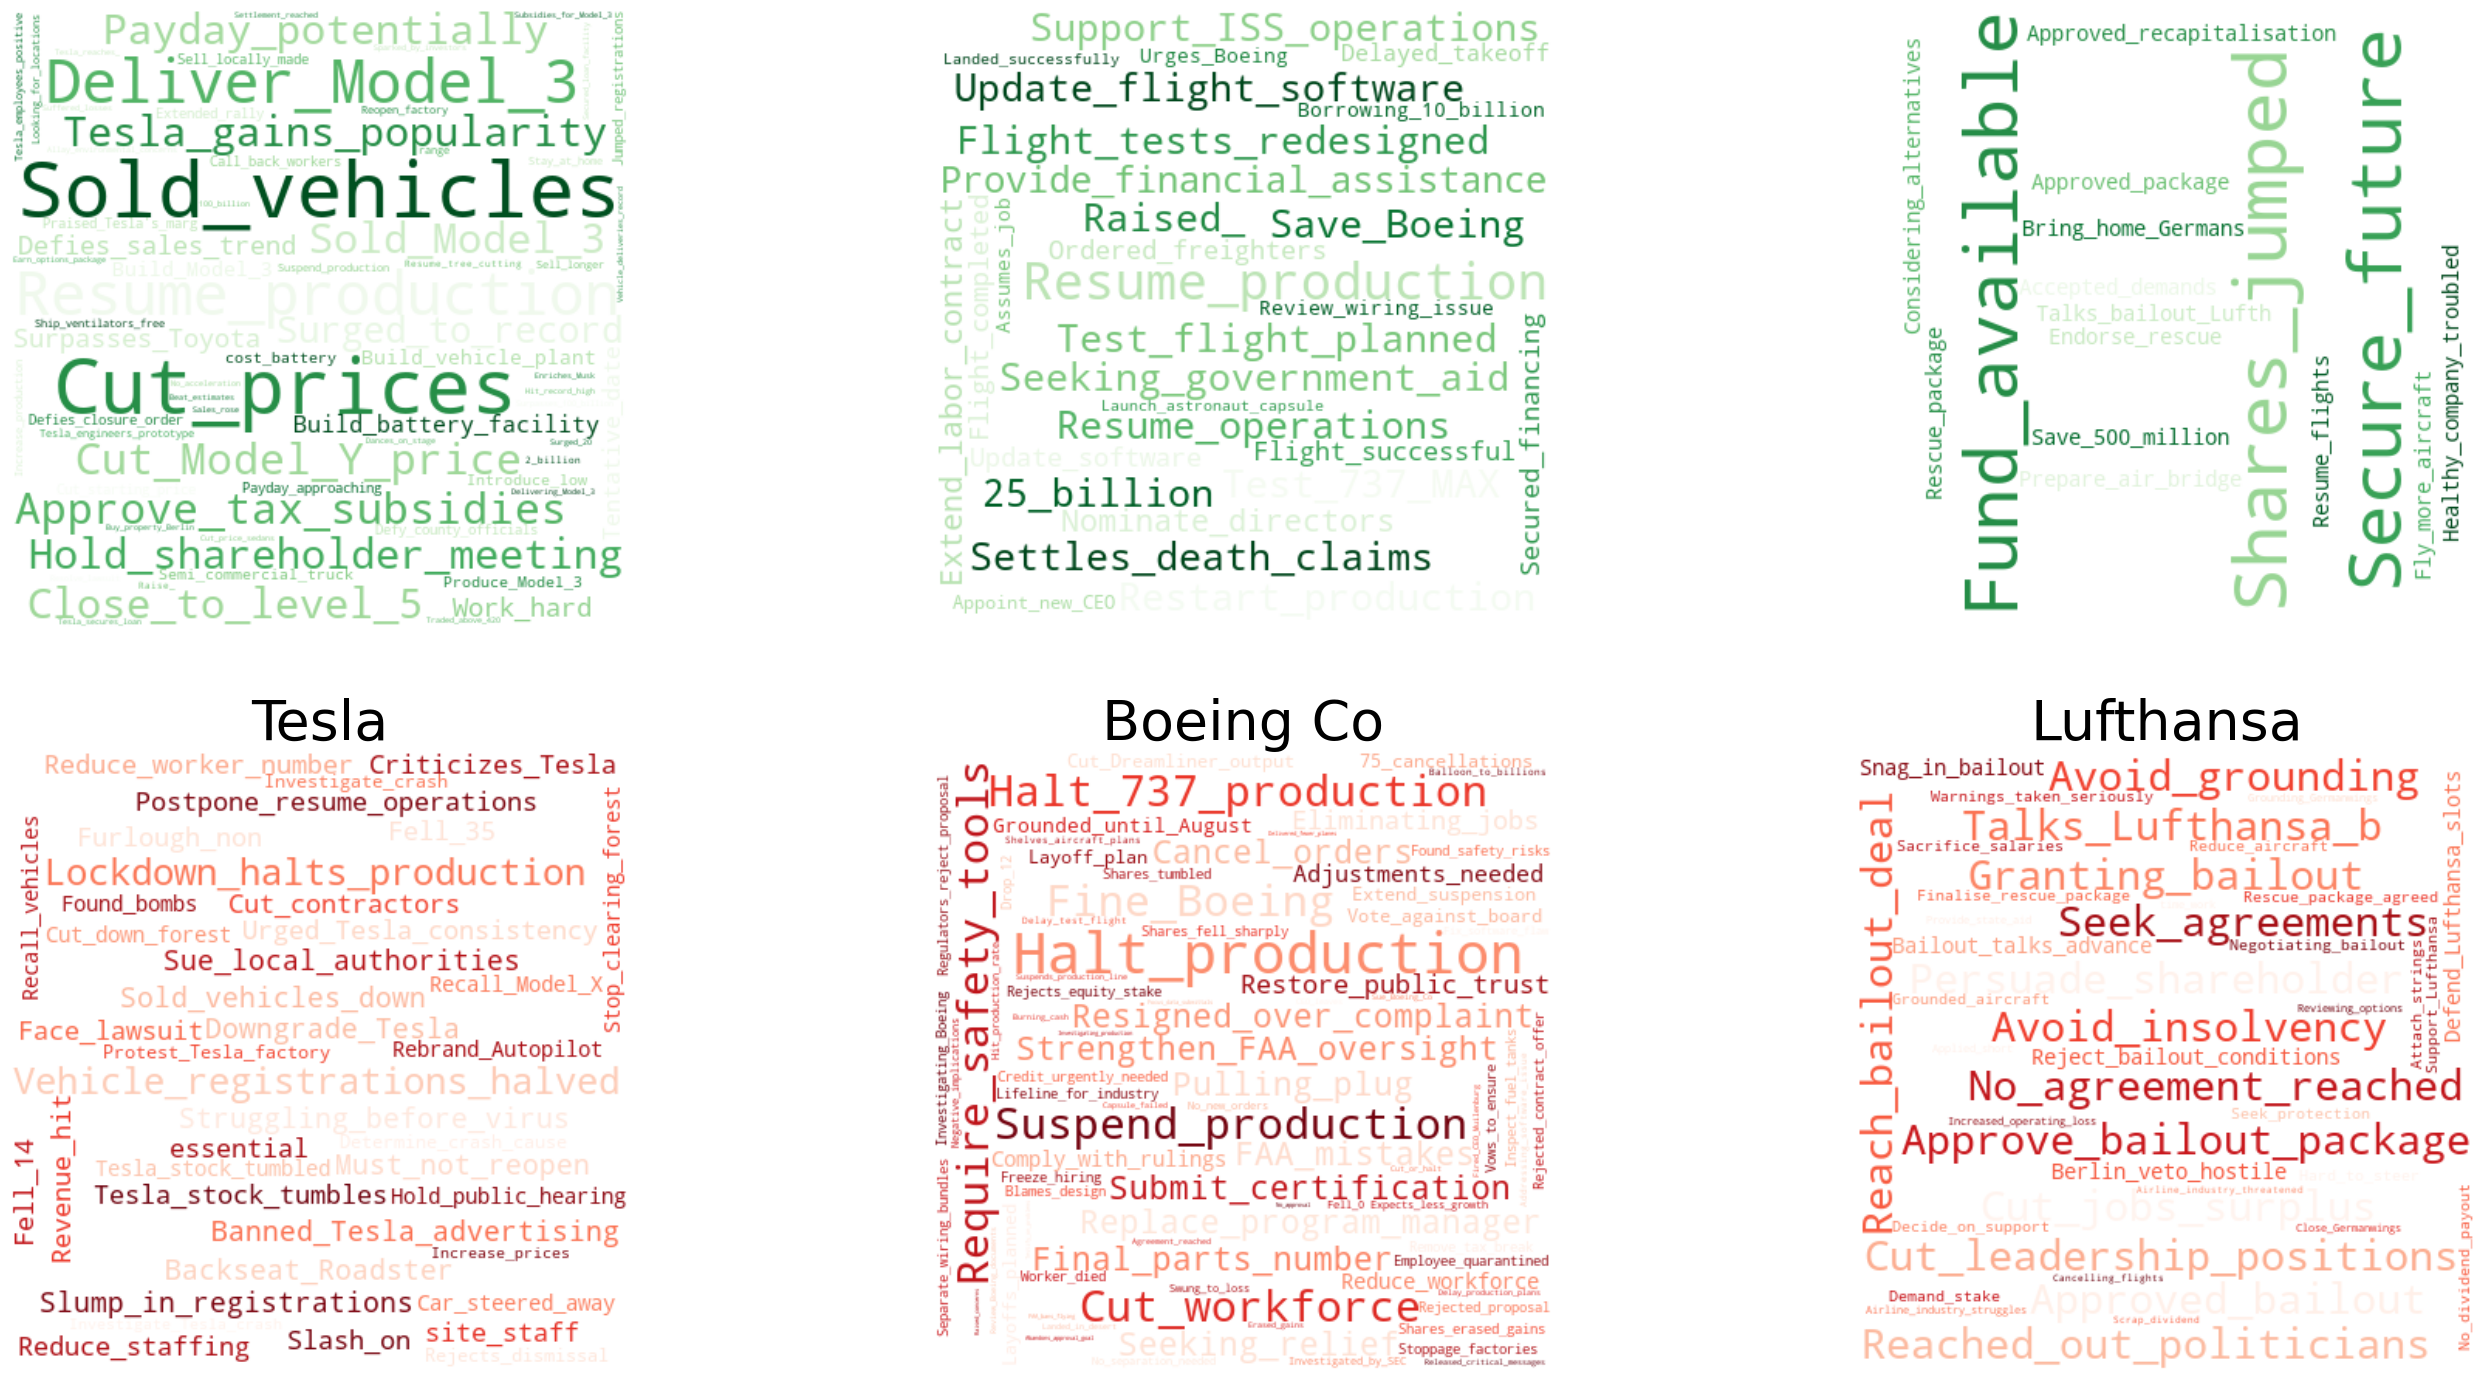

In [67]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load the provided CSV fil
df=load_latest_snapshot_from_csv()

# Count occurrences of each company
company_count = Counter(df['company'])

# Select top 3 companies for visualization
top_3_companies = [company[0] for company in company_count.most_common(3)]

# Filter dataframe for positive and negative sentiments
positive_df = df[df['sentiment'] == 'positive']
negative_df = df[df['sentiment'] == 'negative']

# Function to prepare word cloud data keeping key actions intact
def prepare_wordcloud_data(df):
    # Replace spaces within key actions with underscores
    modified_key_actions = df['key_action'].str.replace(' ', '_')
    # Join the modified key actions with a newline
    return ' \n '.join(modified_key_actions.tolist())

# Preparing word cloud data for positive and negative sentiments for each company
wordcloud_data = {}
for company in top_3_companies:
    pos_data = prepare_wordcloud_data(positive_df[positive_df['company'] == company])
    neg_data = prepare_wordcloud_data(negative_df[negative_df['company'] == company])
    wordcloud_data[company] = {'positive': pos_data, 'negative': neg_data}

# Creating and displaying word clouds
num_companies = len(top_3_companies)
plt.figure(figsize=(10 * num_companies, 15))  # Adjust the size as needed

for i, company in enumerate(top_3_companies):
    # Generate the positive word cloud if there is positive data
    if wordcloud_data[company]['positive']:
        ax1 = plt.subplot(2, num_companies, i + 1)  # Adjust the index for positive word cloud
        pos_wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='Greens', collocations=False).generate(wordcloud_data[company]['positive'])
        plt.imshow(pos_wordcloud, interpolation='bilinear')
        plt.axis("off")
        
    # Generate the negative word cloud if there is negative data
    if wordcloud_data[company]['negative']:
        ax2 = plt.subplot(2, num_companies, num_companies + i + 1)  # Adjust the index for negative word cloud
        ax2.set_title(f'{company}', fontsize=40)
        neg_wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='Reds', collocations=False).generate(wordcloud_data[company]['negative'])
        plt.imshow(neg_wordcloud, interpolation='bilinear')
        plt.axis("off")

# Adjust layout to prevent overlap
plt.tight_layout(pad=5.0)  # Adjust the padding as needed
plt.show()


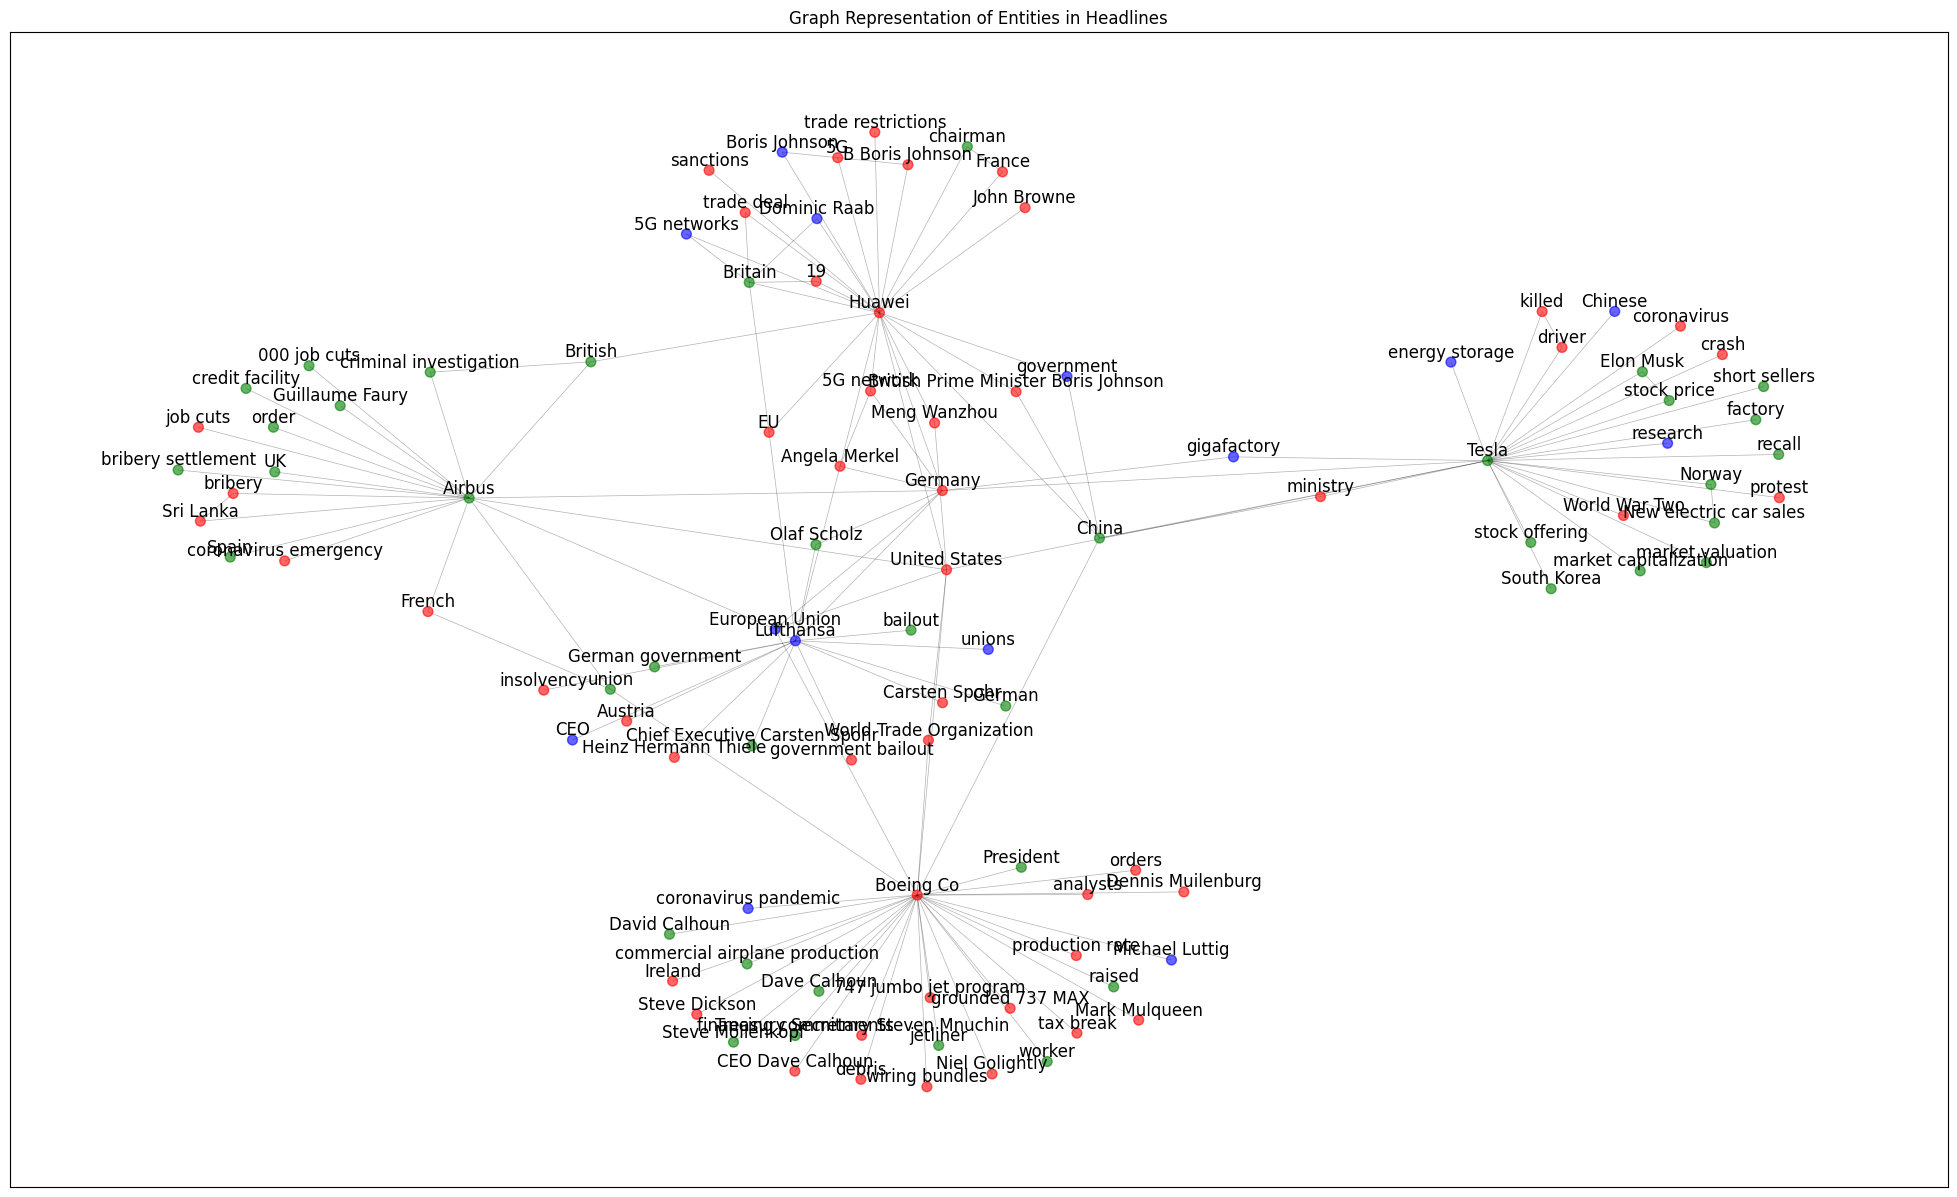

In [75]:

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming df is already loaded and top_3_companies is defined
top_5_companies = [company[0] for company in company_count.most_common(5)]
companies_to_filter = top_5_companies

# Filter rows where the 'company' field is in the top 3 companies
df_filtered = df[df['company'].isin(companies_to_filter)]


entity_sentiment = {}

# Populate the dictionary with sentiment values
for index, row in df.iterrows():
    entities = [row['company'], row['country'], row['person'], row['event'], row['organization']]
    sentiment = row['sentiment']
    for entity in entities:
        if pd.notna(entity):
            # Assign sentiment to the entity
            entity_sentiment[entity] = sentiment

# Modify the node color assignment in the graph drawing
node_colors = [entity_sentiment.get(node, "blue") for node in G.nodes()]  # Default to blue if sentiment is unknown



# Initialize a graph
G = nx.Graph()

# Add nodes and edges to the graph
for index, row in df_filtered.iterrows():
    entities = [row['company'], row['country'], row['person'], row['event'], row['organization']]
    entities = [entity for entity in entities if pd.notna(entity)]  # Remove NaN values

    for i in range(len(entities)):
        G.add_node(entities[i])  # Add entity as node
        for j in range(i + 1, len(entities)):
            # Add an edge if another entity is in the same row
            G.add_edge(entities[i], entities[j])

# Set the layout for our nodes.
pos = nx.spring_layout(G, k=0.1, iterations=20)
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}


# Map sentiment to color
sentiment_color_map = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'blue'  # Default color for neutral or other sentiments
}

# Update the node_colors list to use the mapped colors
node_colors = [sentiment_color_map.get(entity_sentiment.get(node, 'neutral'), 'blue') for node in G.nodes()]



# Plot the graph with adjusted node and font sizes and with labels offset to avoid overlap with nodes.
plt.figure(figsize=(25, 15))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, alpha=0.6)
nx.draw_networkx_labels(G, label_pos, font_size=12, font_color='black')
plt.title("Graph Representation of Entities in Headlines")
plt.show()


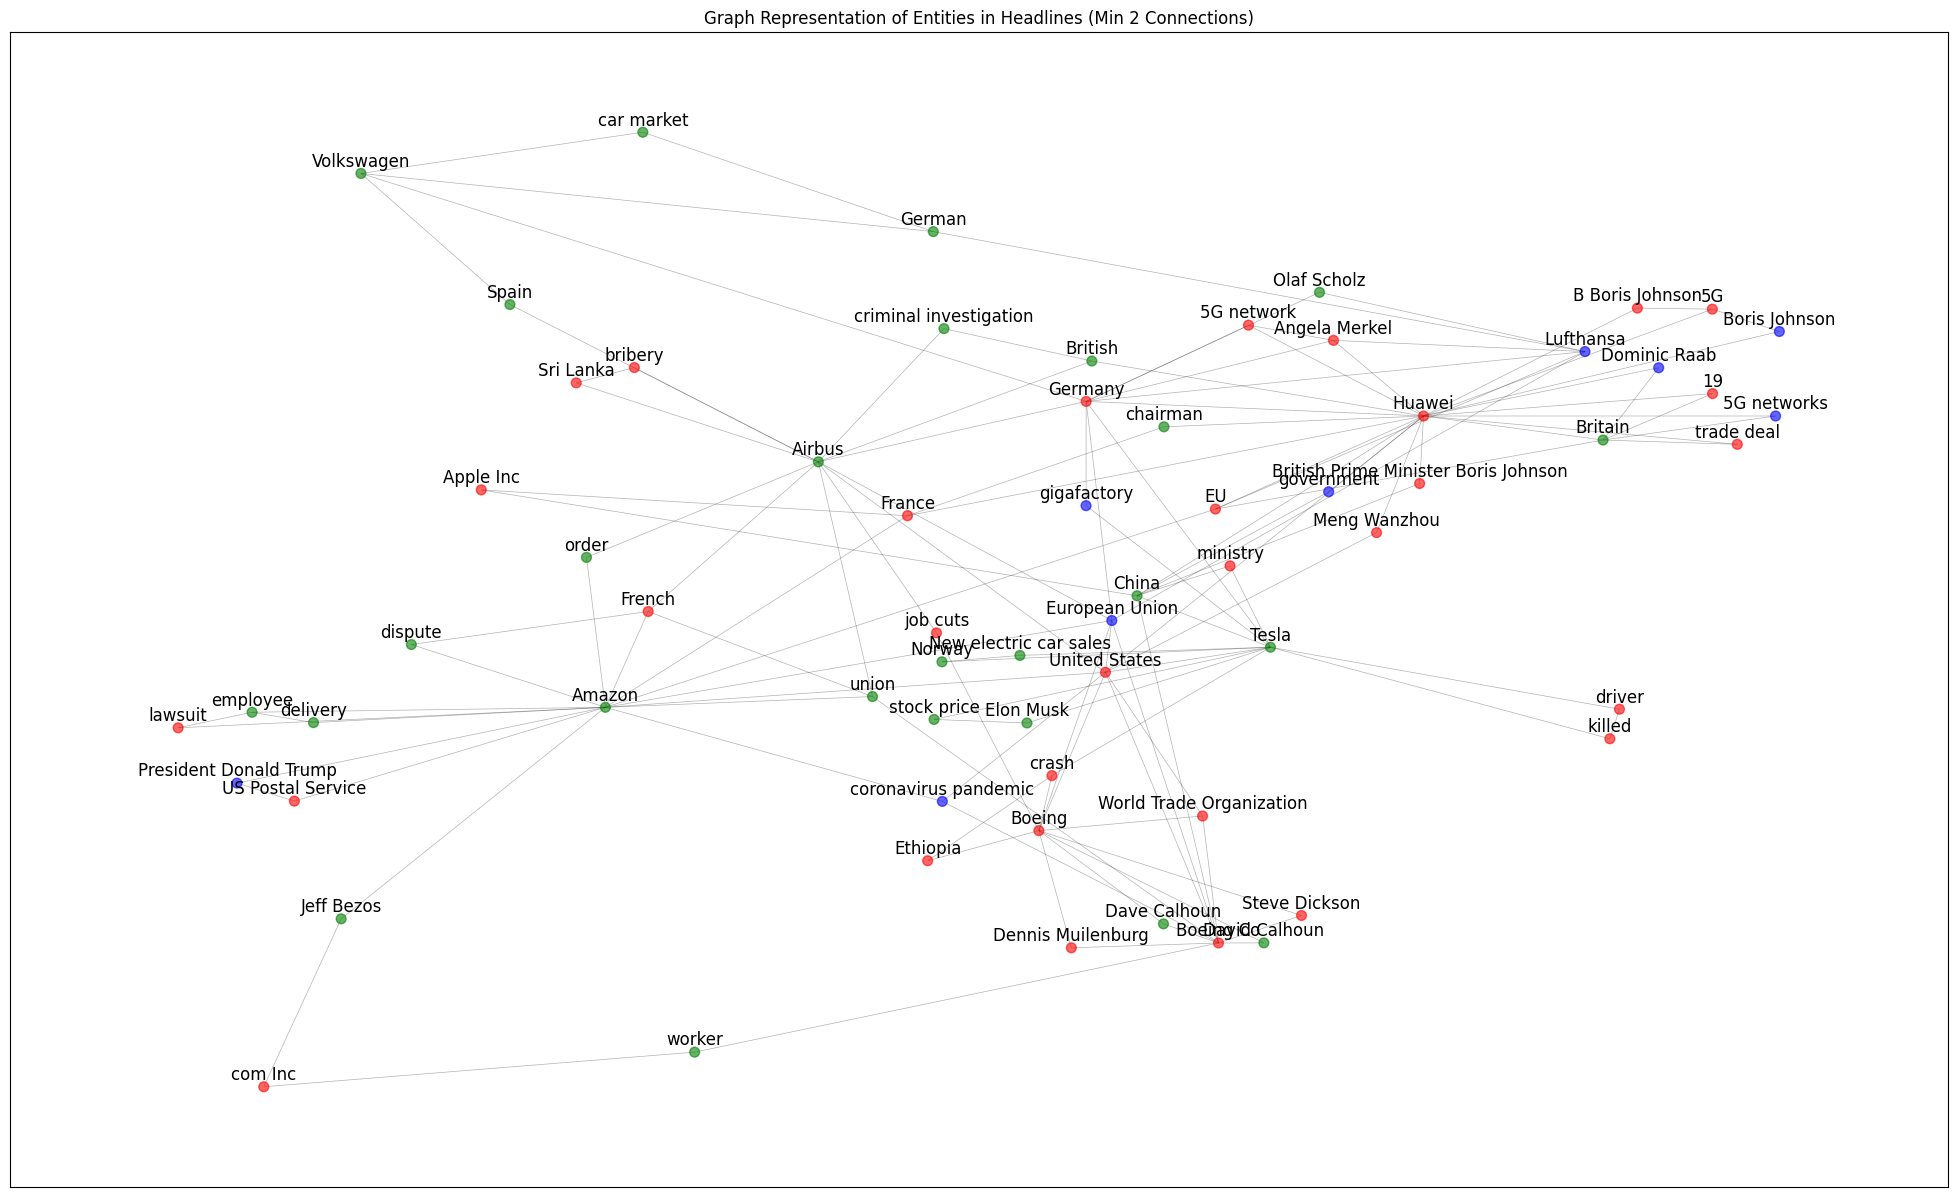

In [80]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming df is already loaded and top_5_companies is defined
top_5_companies = [company[0] for company in company_count.most_common(10)]
companies_to_filter = top_5_companies

# Filter rows where the 'company' field is in the top 5 companies
df_filtered = df[df['company'].isin(companies_to_filter)]

# Initialize a graph
G = nx.Graph()

# Add nodes and edges to the graph
for index, row in df_filtered.iterrows():
    entities = [row['company'], row['country'], row['person'], row['event'], row['organization']]
    entities = [entity for entity in entities if pd.notna(entity)]  # Remove NaN values

    for i in range(len(entities)):
        G.add_node(entities[i])  # Add entity as node
        for j in range(i + 1, len(entities)):
            # Add an edge if another entity is in the same row
            G.add_edge(entities[i], entities[j])

# Filter nodes with degree >= 2
nodes_with_min_degree = [node for node, degree in G.degree() if degree >= 2]

# Create a subgraph with these nodes
H = G.subgraph(nodes_with_min_degree)

# Set the layout for our nodes
pos = nx.spring_layout(G, k=0.04, iterations=20)
subgraph_pos = {node: pos[node] for node in H.nodes()}

# Create a dictionary to store the sentiment for each entity
entity_sentiment = {}

# Populate the dictionary with sentiment values
for index, row in df.iterrows():
    entities = [row['company'], row['country'], row['person'], row['event'], row['organization']]
    sentiment = row['sentiment']
    for entity in entities:
        if pd.notna(entity):
            # Assign sentiment to the entity
            entity_sentiment[entity] = sentiment

# Map sentiment to color
sentiment_color_map = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'blue'  # Default color for neutral or other sentiments
}

# Update the node_colors list to use the mapped colors for the subgraph
subgraph_node_colors = [sentiment_color_map.get(entity_sentiment.get(node, 'neutral'), 'blue') for node in H.nodes()]

# Plot the subgraph
plt.figure(figsize=(25, 15))
nx.draw_networkx_edges(H, subgraph_pos, alpha=0.3, width=0.5)
nx.draw_networkx_nodes(H, subgraph_pos, node_size=50, node_color=subgraph_node_colors, alpha=0.6)
nx.draw_networkx_labels(H, {node: (x, y + 0.02) for node, (x, y) in subgraph_pos.items()}, font_size=12, font_color='black')
plt.title("Graph Representation of Entities in Headlines (Min 2 Connections)")
plt.show()


In [ ]:
# import ast
# import networkx as nx
# import matplotlib.pyplot as plt

# df = load_latest_snapshot_from_csv()
# companies_to_filter = top_3_companies

# rows_to_add = []

# for i in range(df.shape[0]):
#     for entities in df["named_entities"][i]:
#         if entities[0] in companies_to_filter:
#             rows_to_add.append(df.iloc[i])

# df_filtered = pd.concat(rows_to_add, axis=1).transpose()

# # Initialize a graph
# G = nx.Graph()

# # Add nodes and edges to the graph
# for entities in df_filtered['named_entities']:
#     for i in range(len(entities)):
#         G.add_node(entities[i][0])  # Add entity as node
#         for j in range(i + 1, len(entities)):
#             # Add an edge if another entity is in the same headline
#             G.add_edge(entities[i][0], entities[j][0])
            
            
# # nx.draw_networkx(G, with_labels=True, node_size=20, font_size=8)
# # Set the layout for our nodes.
# pos = nx.spring_layout(G, k=0.15, iterations=20)
# label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}

# # Plot the graph with adjusted node and font sizes and with labels offset to avoid overlap with nodes.
# plt.figure(figsize=(18, 15))
# nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
# nx.draw_networkx_nodes(G, pos, node_size=50, node_color="blue", alpha=0.6)
# nx.draw_networkx_labels(G, label_pos, font_size=12, font_color='black')


# # Plot the graph
# plt.figure(figsize=(18, 15))
# plt.title("Graph Representation of Named Entities in Headlines")
# plt.show()


KeyError: 'named_entities'

In [ ]:
# df = load_latest_snapshot_from_csv()
# companies_to_filter = ["TikTok", "Walt Disney"]

# rows_to_add = []

# for i in range(df.shape[0]):
#     for entities in df["named_entities"][i]:
#         if entities[0] in companies_to_filter:
#             print("found in " + str(i))
#             rows_to_add.append(df.iloc[i])

# df_filtered = pd.concat(rows_to_add, axis=1).transpose()
